# Plotting code for the stellar system evolution and fitting

This notebook produces figures 1-4 in the paper "Stellar cores live long and prosper in cuspy dark matter halos."

Jenni Häkkinen (jenni.hakkinen@helsinki.fi) 2025

## Imports and settings

In [5]:
# Modules
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patheffects as pe

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

from scipy.optimize import root_scalar
from scipy.stats import gaussian_kde

# Figure settings
from figure_settings import cmap_times, cmap_masses, cmap_fiducials, color_orange

%matplotlib inline

In [ ]:
# Unzip the data folder
! unzip ../data.zip -d ../data_test

## Helper class for the analytic Plummer model

In [2]:
class PlummerModel:
    """
    Functions for evaluating the Plummer density profile, enclosed mass,
    and Lagrangian radii.

    Parameters
    ----------
    mass_tot : float
        Total stellar mass (default 5.e3) [Msol]
    rS : float
        Plummer scale radius (default 0.2) [kpc]
    """

    def __init__(self, mass_tot=5.e3, rS=0.2):
        self.mass_tot = mass_tot
        self.rS = rS

        # Characteristic density
        self.rhoS = 3 * self.mass_tot / (4 * np.pi * self.rS**3)

    def density(self, radii):
        """
        Stellar density at given radii using the Plummer model.

        Parameters
        ----------
        radii : array-like
            Radii at which to evaluate density [kpc]

        Returns
        -------
        : np.ndarray
            Stellar densities [Msol / kpc^3]
        """

        factor = 3 * self.mass_tot / (4 * np.pi * self.rS**3)
        return factor * np.power(1 + np.asarray(radii)**2 / self.rS**2, -2.5)

    def mass(self, r):
        """
        Plummer enclosed mass at radius r.

        Parameters
        ----------
        r : float or array-like
            Radius [kpc]

        Returns
        -------
        mass : float or np.ndarray
            Enclosed stellar mass [Msol]
        """
        r = np.asarray(r)
        return self.mass_tot * r**3 / np.power(r**2 + self.rS**2, 1.5)

    def lagrangian_radius(self, frac=0.35):
        """
        Solve for the radius enclosing a given mass fraction.

        Parameters
        ----------
        frac : float
            Fraction of total mass (default 0.35)

        Returns
        -------
        : float
            Lagrangian radius [kpc]
        """

        def diff(r):
            # mass(r) - frac * total mass
            return self.mass(r) - frac * self.mass_tot

        sol = root_scalar(
            diff,
            bracket=[1e-6, 10],
            method='brentq'
        )

        return sol.root

In [3]:
P = PlummerModel(mass_tot=5e3, rS=0.2)

## Stellar density and velocity anisotropy evolution (figure 1)

Text(0.5, 0, '$r\\,[\\mathrm{kpc}]$')

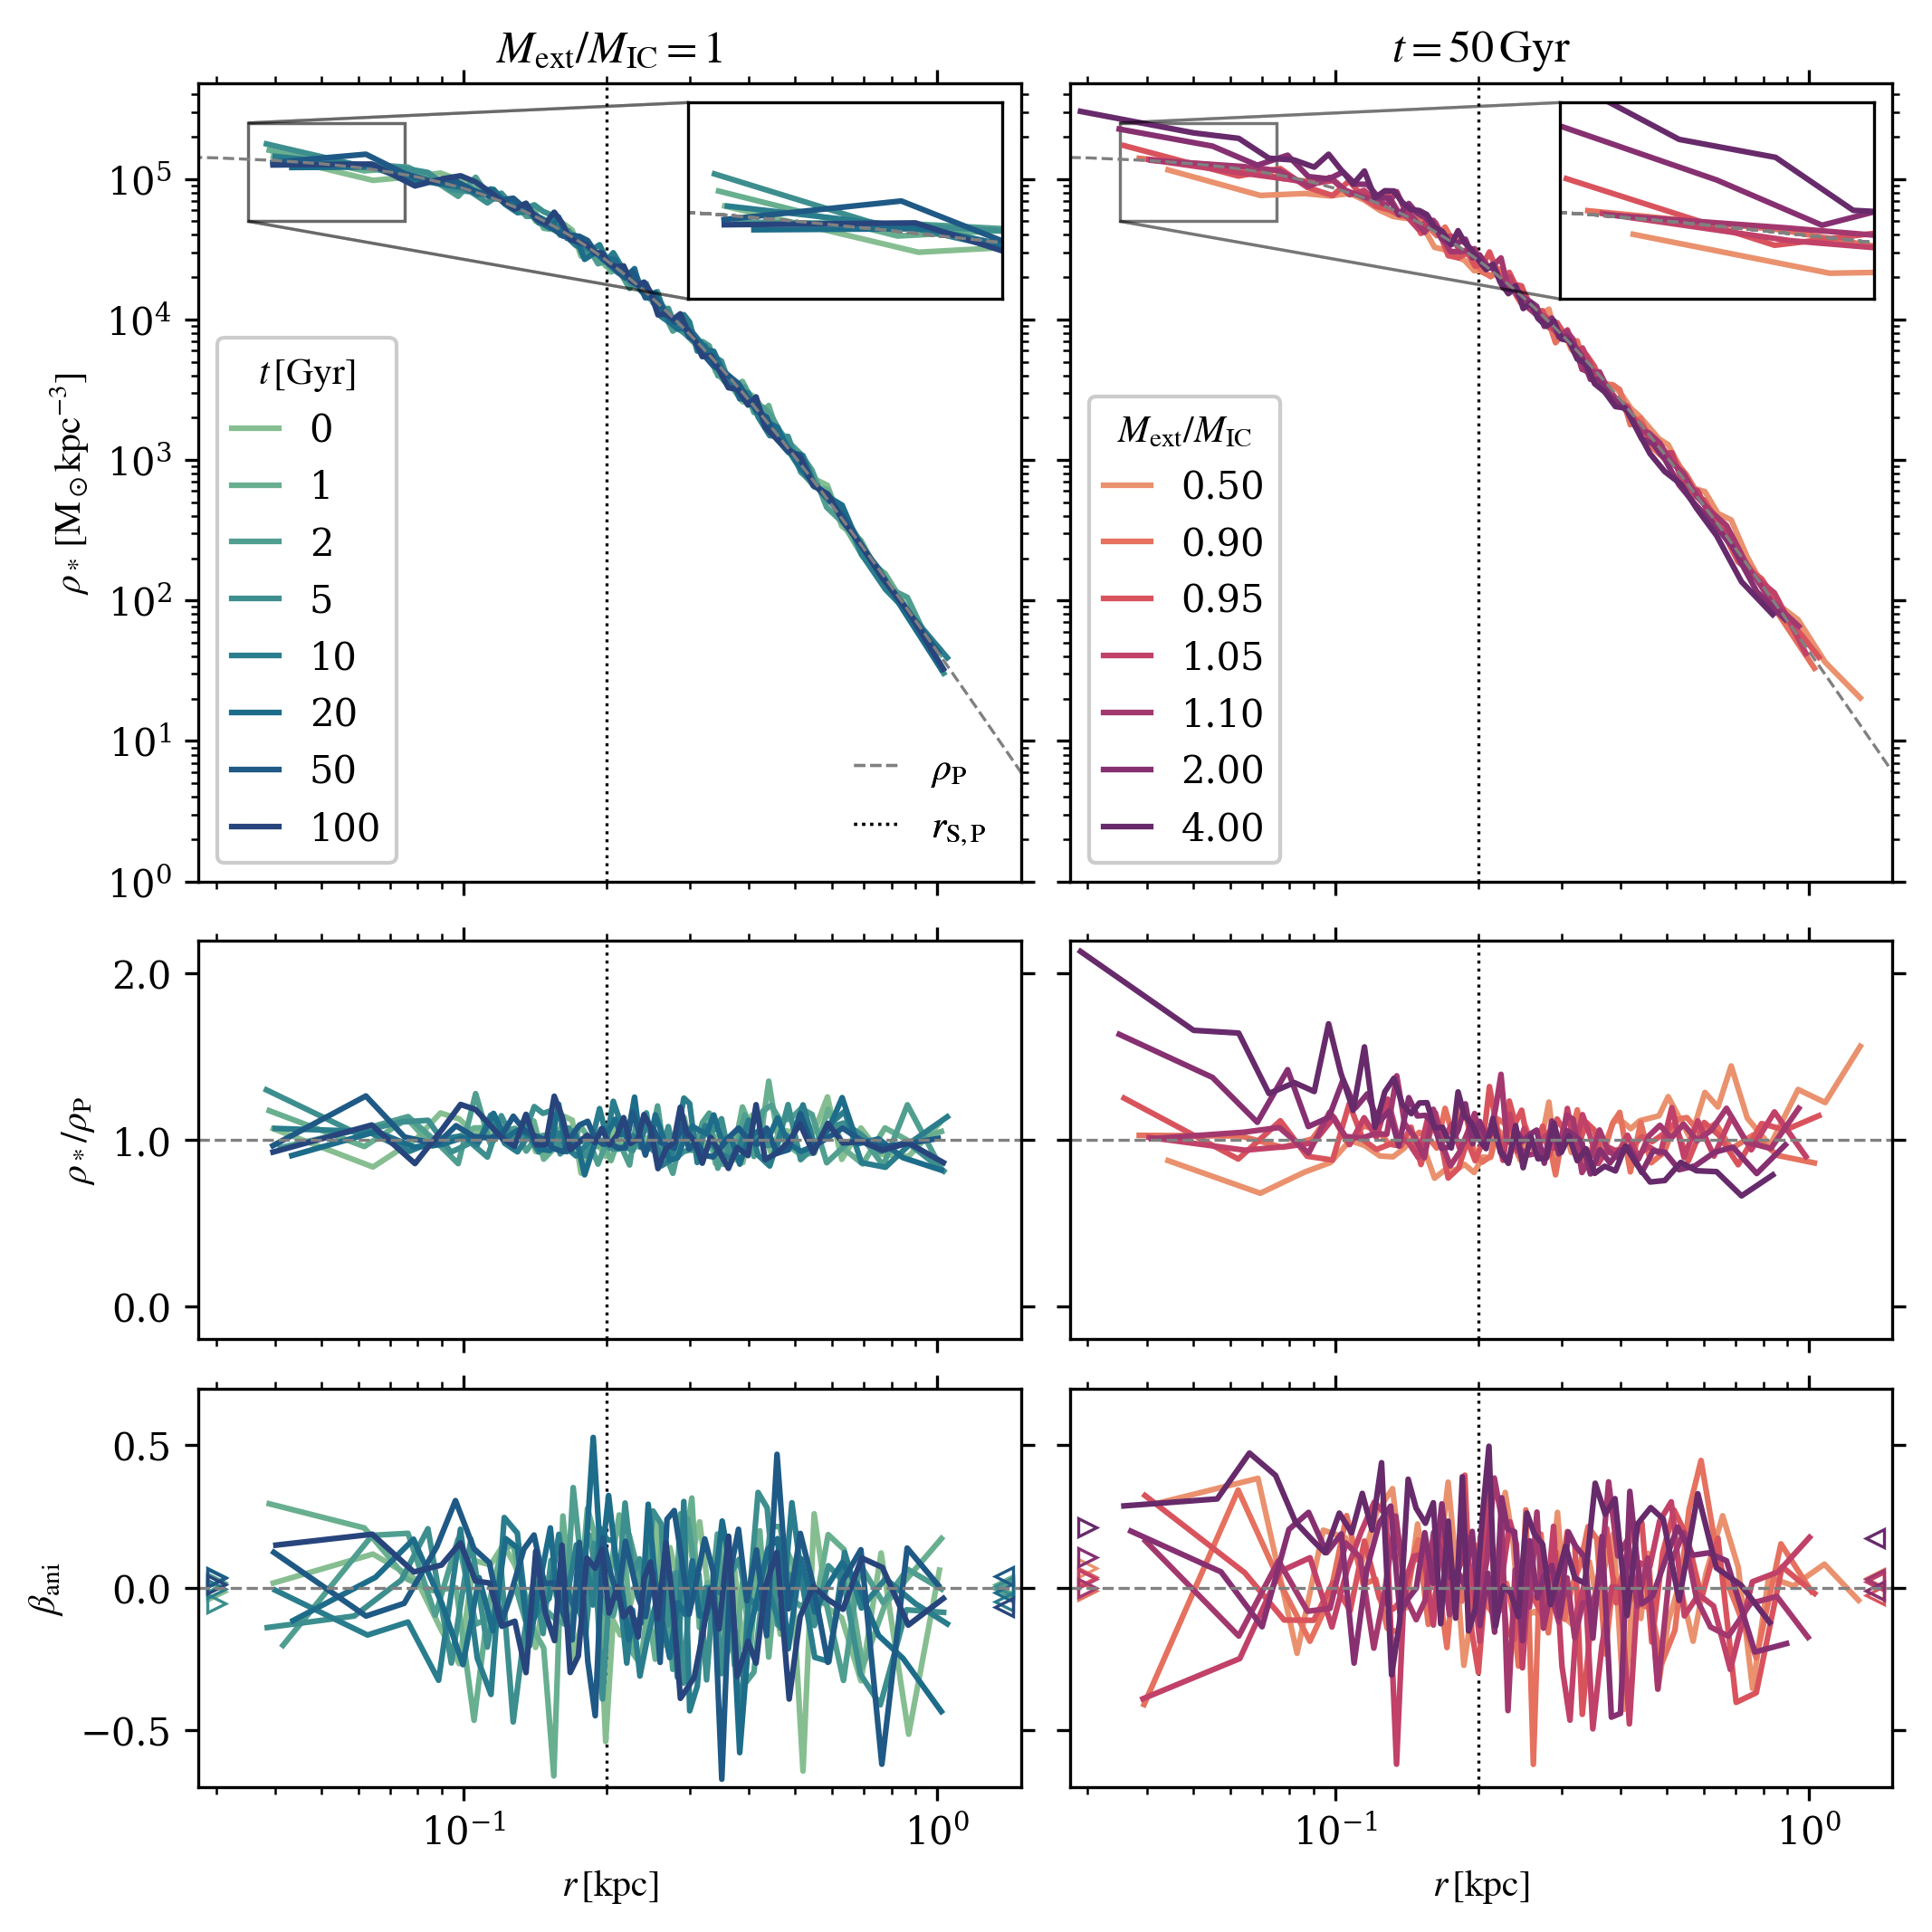

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(7, 7), sharey='row', sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]}, layout='constrained')

axis_color = ax[0, 0].spines["left"].get_edgecolor()
axis_width = ax[0, 0].spines["left"].get_linewidth()

for i, axis in enumerate(ax.flatten()):
    if i == 1:
        rS = axis.axvline(0.2, linestyle='dotted', linewidth=axis_width, color=axis_color, label=r'$r_\mathrm{S, P}$')
    else:
        axis.axvline(0.2, linestyle='dotted', linewidth=axis_width, color=axis_color)

r = np.linspace(0.01, 10, 1000)
plummer_r = P.density(r)

### LEFT COLUMN ###

years = [0, 1, 2, 5, 10, 20, 50, 100]
axins = zoomed_inset_axes(ax[0, 0], zoom=2, loc="upper right")

dens = []
for i, y in enumerate(years):

    ### TOP-LEFT PANEL ###
    file = f'../data/density_profiles/fiducial_0/stellar_density_fiducial_0_{int(years[i]):03}Gyr_cut95_nbins50.txt'
    radii, densities = np.loadtxt(file, skiprows=1, unpack=True)
    dens += ax[0, 0].plot(radii, densities, label=f'{years[i]}', color=cmap_times[i])

    # Zoom-in panel of central region
    axins.plot(radii, densities, color=cmap_times[i])
    axins.plot(r, plummer_r, linestyle='--', color='grey', linewidth=axis_width)

    r1, r2, d1, d2 = 0.035, 0.075, 5e4, 2.5e5
    axins.set_xlim(r1, r2)
    axins.set_ylim(d1, d2)
    axins.set_xticks([])
    axins.set_yticks([])

    mark_inset(ax[0, 0], axins,
               loc1=2, loc2=3,
               alpha=0.1,
               fc="none",
               ec=axis_color,
               lw=axis_width)

    ### MIDDLE-LEFT PANEL ###
    plummer_radii = P.density(radii)
    ratio = [x / y for x, y in zip(densities, plummer_radii)]
    ax[1, 0].plot(radii, ratio, color=cmap_times[i])

    ### BOMMON-LEFT PANEL ###
    file = f'../data/beta_profiles/fiducial_0/nbins50/beta_fiducial_0_{int(years[i]):03}Gyr_cut95_nbins50.txt'
    radii, betas = np.loadtxt(file, skiprows=1, unpack=True)
    ax[2, 0].plot(radii, betas, color=cmap_times[i])

    # Average markers for beta within and outside the Plummer scale radius
    file = f'../data/beta_profiles/fiducial_0/nbins2/beta_fiducial_0_{int(years[i]):03}Gyr_cut95_nbins2.txt'
    radii, betas = np.loadtxt(file, skiprows=1, unpack=True)

    inner = radii <= 0.2
    outer = radii > 0.2

    ax[2, 0].plot(0.03, np.mean(betas[inner]), color=cmap_times[i], marker='>', fillstyle='none', markersize=5, markeredgewidth=axis_width)
    ax[2, 0].plot(1.38, np.mean(betas[outer]), color=cmap_times[i], marker='<', fillstyle='none', markersize=5, markeredgewidth=axis_width)

plummer = ax[0, 0].plot(r, plummer_r, linestyle='--', color='grey', linewidth=axis_width, label=r'$\rho_\mathrm{P}$')
ax[0 ,0].set_yscale('log')
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylim([1, None])
ax[0, 0].set_xlim([0.0275, 1.5])
ax[0, 0].set_ylabel(r'$\rho_*\,[\mathrm{M}_\odot \mathrm{kpc}^{-3}]$')
ax[0, 0].set_title(r'$M_\mathrm{ext} / M_\mathrm{IC}=1$')

ax00legend1 = ax[0, 0].legend(handles=dens, title=r'$t\,[\mathrm{Gyr}]$', loc='lower left')
ax[0, 0].add_artist(ax00legend1)
ax00legend2 = ax[0, 0].legend(handles=plummer + [rS], loc='lower right', frameon=False)
ax[0, 0].add_artist(ax00legend2)

ax[1, 0].axhline(1, linestyle='--', color='grey', linewidth=axis_width)
ax[1, 0].set_ylim([-0.2, 2.2])
ax[1, 0].set_yticks([0, 1.0, 2.0])
ax[1, 0].set_yticklabels([0.0, 1.0, 2.0])
ax[1, 0].set_ylabel(r'$\rho_* / \rho_\mathrm{P}$')

ax[2, 0].axhline(0, linestyle='--', color='grey', linewidth=axis_width)
ax[2, 0].set_xscale('log')
ax[2, 0].set_ylim([-0.7, 0.7])
ax[2, 0].set_ylabel(r'$\beta_\mathrm{ani}$')
ax[2, 0].set_xlabel(r'$r\,[\mathrm{kpc}]$')

### RIGHT COLUMN ###

mass_ratio = [0.5, 0.9, 0.95, 1.05, 1.1, 2, 4]
axins = zoomed_inset_axes(ax[0, 1], zoom=2, loc="upper right")

# rho_*
file_pattern_d = f'../data/density_profiles/*xMvir/stellar_density_*xMvir_050Gyr_cut95_nbins50.txt'
file_list_d = sorted(glob(file_pattern_d))

# rho_* / rho_P
file_pattern_r = f'../data/density_profiles/*xMvir/stellar_density_*xMvir_ratio_050Gyr_cut95_nbins50.txt'
file_list_r = sorted(glob(file_pattern_r))

# beta_ani (50 bins)
file_pattern_b50 = f'../data/beta_profiles/*xMvir/beta_*xMvir_050Gyr_cut95_nbins50.txt'
file_list_b50 = sorted(glob(file_pattern_b50))

# beta_ani (2 bins)
file_pattern_b2 = f'../data/beta_profiles/*xMvir/beta_*xMvir_050Gyr_cut95_nbins2.txt'
file_list_b2 = sorted(glob(file_pattern_b2))

dens = []
for i, m in enumerate(mass_ratio):

    ### TOP-RIGHT PANEL ###
    radii, densities = np.loadtxt(file_list_d[i], skiprows=1, unpack=True)
    dens += ax[0, 1].plot(radii, densities, label=f'{m:.2f}', color=cmap_masses[i])

    # Zoom-in panel of central region
    axins.plot(radii, densities, color=cmap_masses[i])
    axins.plot(r, plummer_r, linestyle='--', color='grey', linewidth=axis_width)

    r1, r2, d1, d2 = 0.035, 0.075, 5e4, 2.5e5
    axins.set_xlim(r1, r2)
    axins.set_ylim(d1, d2)
    axins.set_xticks([])
    axins.set_yticks([])

    mark_inset(ax[0, 1], axins,
               loc1=2, loc2=3,
               alpha=0.1,
               fc="none",
               ec=axis_color,
               lw=axis_width)

    ### MIDDLE-RIGHT PANEL ###
    radii, ratio = np.loadtxt(file_list_r[i], skiprows=1, unpack=True)
    ax[1, 1].plot(radii, ratio, color=cmap_masses[i])

    # BOTTOM-RIGHT PANEL ###
    radii, betas = np.loadtxt(file_list_b50[i], skiprows=1, unpack=True)
    ax[2, 1].plot(radii, betas, color=cmap_masses[i])

    # Average markers for beta within and outside the Plummer scale radius
    radii, betas = np.loadtxt(file_list_b2[i], skiprows=1, unpack=True)
    inner = radii <= 0.2
    outer = radii > 0.2

    ax[2, 1].plot(0.03, np.mean(betas[inner]), color=cmap_masses[i], marker='>', fillstyle='none', markersize=5, markeredgewidth=axis_width)
    ax[2, 1].plot(1.38, np.mean(betas[outer]), color=cmap_masses[i], marker='<', fillstyle='none', markersize=5, markeredgewidth=axis_width)

plummer = ax[0, 1].plot(r, plummer_r, linestyle='--', color='grey', label=r'$\rho_\mathrm{P}$', linewidth=axis_width)
ax[0, 1].set_title(r'$t = 50\,\mathrm{Gyr}$')

ax01legend1 = ax[0, 1].legend(handles=dens, title=r'$M_\mathrm{ext} / M_\mathrm{IC}$', loc='lower left')
ax[0, 1].add_artist(ax01legend1)

ax[1, 1].axhline(1, linestyle='--', color='grey', linewidth=axis_width)

ax[2, 1].axhline(0, linestyle='--', color='grey', linewidth=axis_width)
ax[2, 1].set_xscale('log')
ax[2, 1].set_xlabel(r'$r\,[\mathrm{kpc}]$')

## Evolution of ten fiducial systems (figure 2)

In [5]:
def interpolate_and_average(all_radii, all_dens, n_points=50):
    """
    Interpolate multiple (r, density) profiles onto a common radius grid
    and return the average density profile.

    Parameters
    ----------
    all_radii : nested list
        Radii of all systems [kpc]
    all_dens : nested list
        Densities of all systems [Msol / kpc^3]
    n_points : int
        Number of points at which to evaluate the interpolated profiles (default 100)
    
    Returns
    -------
    common_radius : np.array
        Interpolated radii [kpc]
    avg_density : np.array
        Average densities at radii [Msol / kpc^3]
    """

    r_min = max(r.min() for r in all_radii)
    r_max = min(r.max() for r in all_radii)
    common_radius = np.linspace(r_min, r_max, n_points)

    interpolated = []
    for r, d in zip(all_radii, all_dens):
        interp_d = np.interp(common_radius, r, d)
        interpolated.append(interp_d)

    interpolated = np.vstack(interpolated)
    avg_density = interpolated.mean(axis=0)

    return common_radius, avg_density

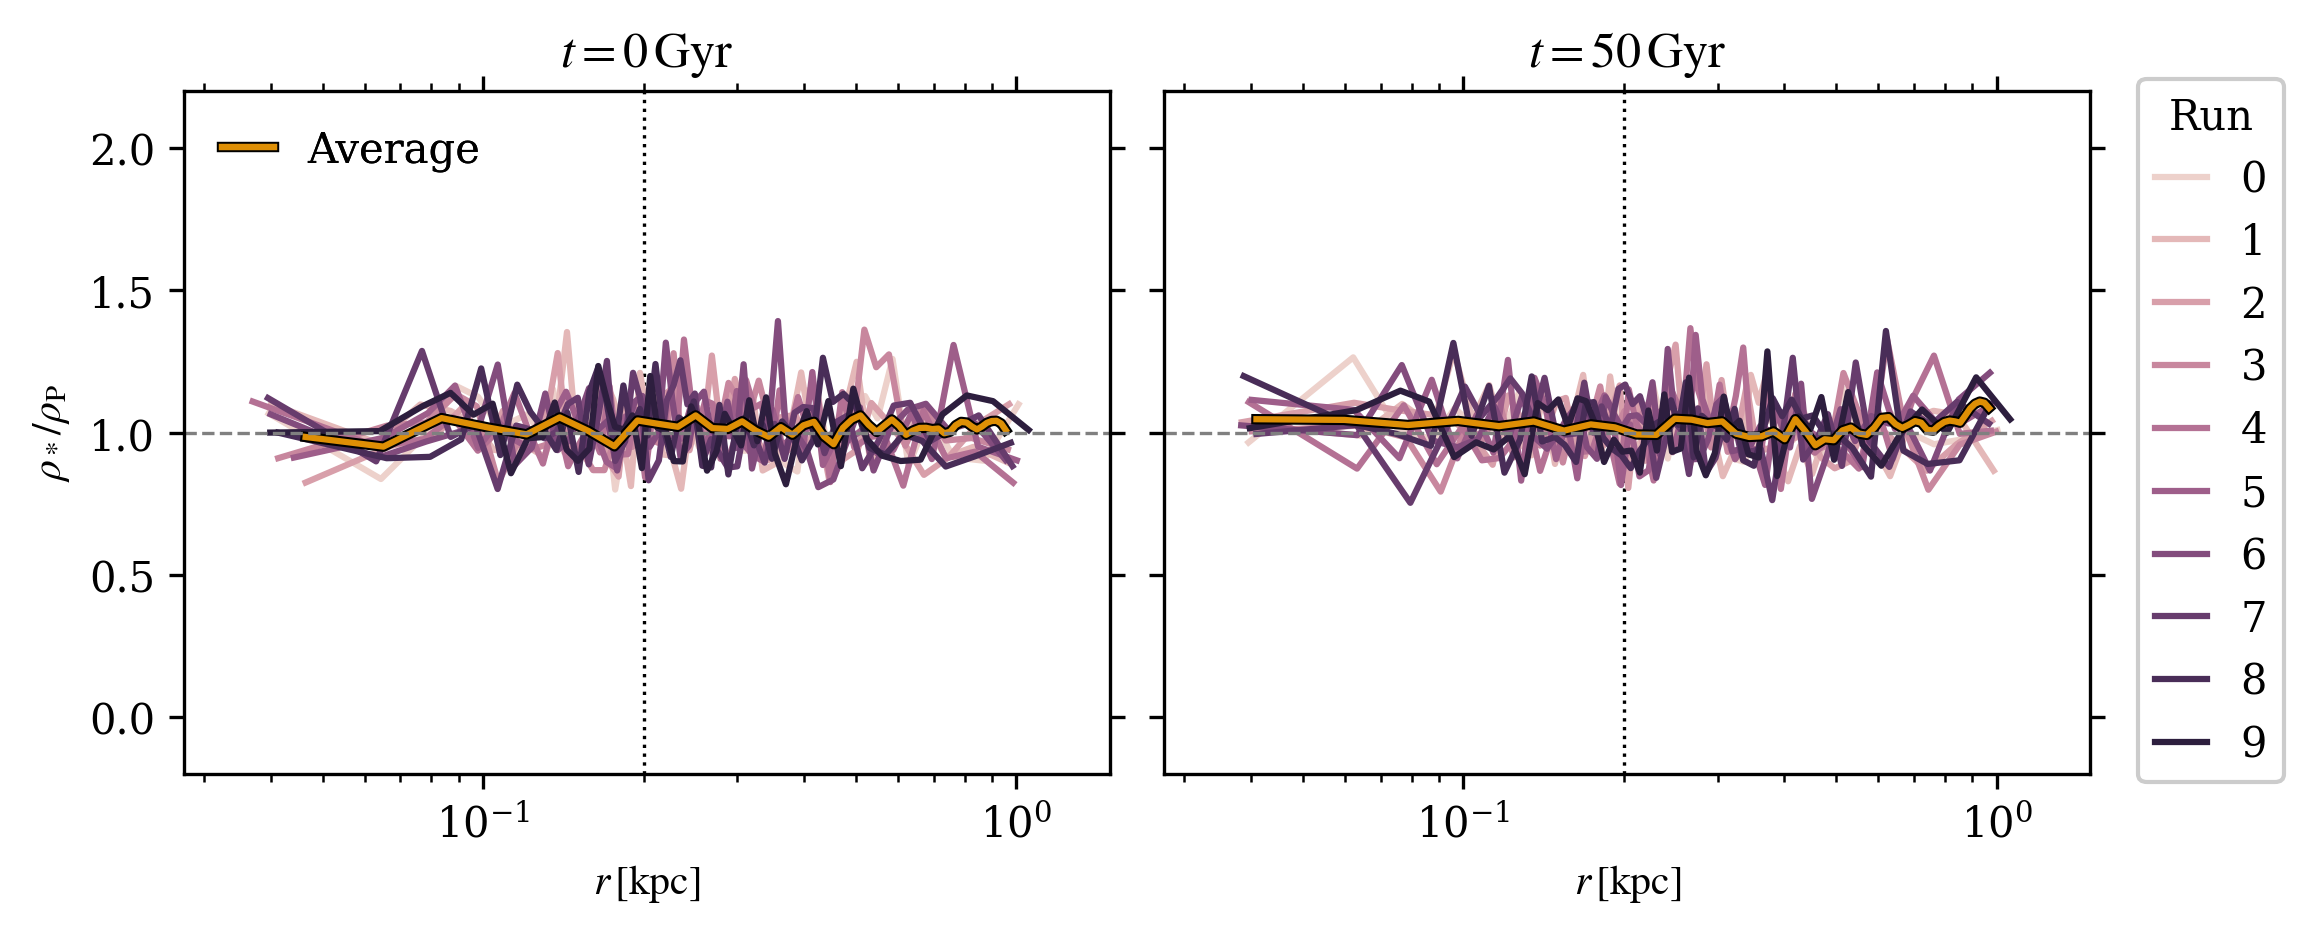

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharey=True, sharex=True, layout='constrained')

axis_color = ax[0].spines["left"].get_edgecolor()
axis_width = ax[0].spines["left"].get_linewidth()

# Plummer scale radius
for axis in ax:
    axis.axvline(0.2, linestyle='dotted', linewidth=axis_width, color=axis_color)

### LEFT PANEL ###

file_pattern = f'../data/density_profiles/fiducial_*/stellar_density_fiducial_*_000Gyr_cut95_nbins50.txt'
file_list = sorted(glob(file_pattern))

all_radii = []
all_dens = []

# Individual runs
for i, file in enumerate(file_list):
    radii, densities = np.loadtxt(file, skiprows=1, unpack=True)
    all_radii.append(radii)
    all_dens.append(densities)

    plummer = P.density(radii)
    ratio = [x / y for x, y in zip(densities, plummer)]
    ax[0].plot(radii, ratio, color=cmap_fiducials[i])

# Interpolate and calculate the average of all runs
common_radius, avg_density = interpolate_and_average(all_radii, all_dens, n_points=50)

result = np.column_stack([common_radius, avg_density])

avg_ratio = [x / y for x, y in zip(avg_density, P.density(common_radius))]

# Create a black outline for the average line
avg1 = ax[0].plot(common_radius, avg_ratio, color='k', linewidth=2.5, label=' ')
avg2 = ax[0].plot(common_radius, avg_ratio, color=color_orange, label='Average')

ax0legend1 = ax[0].legend(handles=avg1, frameon=False, loc='upper left')
ax[0].add_artist(ax0legend1)

ax0legend2 = ax[0].legend(handles=avg2, framealpha=0, loc='upper left')
ax[0].add_artist(ax0legend2)

### RIGHT PANEL ###

file_pattern = f'../data/density_profiles/fiducial_*/stellar_density_fiducial_*_050Gyr_cut95_nbins50.txt'
file_list = sorted(glob(file_pattern))

all_radii = []
all_dens = []

for i, file in enumerate(file_list):
    radii, densities = np.loadtxt(file, skiprows=1, unpack=True)
    all_radii.append(radii)
    all_dens.append(densities)

    plummer = P.density(radii)
    ratio = [x / y for x, y in zip(densities, plummer)]

    ax[1].plot(radii, ratio, color=cmap_fiducials[i], label=i)

# Interpolate and calculate the average of all runs
common_radius, avg_density = interpolate_and_average(all_radii, all_dens, n_points=50)

result = np.column_stack([common_radius, avg_density])

avg_ratio = [x / y for x, y in zip(avg_density, P.density(common_radius))]

# Create a black outline for the average line
avg1 = ax[1].plot(common_radius, avg_ratio, color='k', linewidth=2.5)
avg2 = ax[1].plot(common_radius, avg_ratio, color=color_orange)

# rho_* / rho_P = 1
for axis in ax:
    axis.axhline(1, linestyle='--', color='grey', linewidth=axis_width)

ax[0].set_xscale('log')
ax[0].set_ylim([-0.2, 2.2])
ax[0].set_xlim([0.0275, 1.5])
ax[0].set_ylabel(r'$\rho_* / \rho_\mathrm{P}$')
ax[0].set_xlabel(r'$r\,[\mathrm{kpc}]$')
ax[0].set_title(r'$t=0\,\mathrm{Gyr}$')

ax[1].set_xlabel(r'$r\,[\mathrm{kpc}]$')
ax[1].set_title(r'$t = 50\,\mathrm{Gyr}$')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, title='Run', ncol=1, loc='center left', bbox_to_anchor=(1, 0.54))

## Evolution of the Lagrangian radius $r_{35}$ (figure 3)

In [7]:
def broken_axis_map(x, breaks, widths, gap):
    """
    Helper function for mapping axis values to broken intervals.

    Parameters
    ----------
    x : np.array
        Values to map
    breaks : list
        Values where the axis changes (start, middle, end)
    widths : list
        Widths of the different axis intervals as a fraction of 1
    gap : int
        Gap in plotting at the break

    Returns
    -------
    out : np.array
        Mapped x-axis values for the broken intervals
    """

    breaks = np.array(breaks, dtype=float)
    widths = np.array(widths, dtype=float)

    out = np.full_like(x, np.nan, dtype=float)
    mapped_start = 0.0

    for i in range(len(widths)):
        x0, x1 = breaks[i], breaks[i+1]
        mask = (x >= x0) & (x <= x1)

        if x1 == x0:
            out[mask] = mapped_start
        else:
            out[mask] = mapped_start + (x[mask] - x0) / (x1 - x0) * widths[i]

        mapped_start += widths[i] + gap

    return out

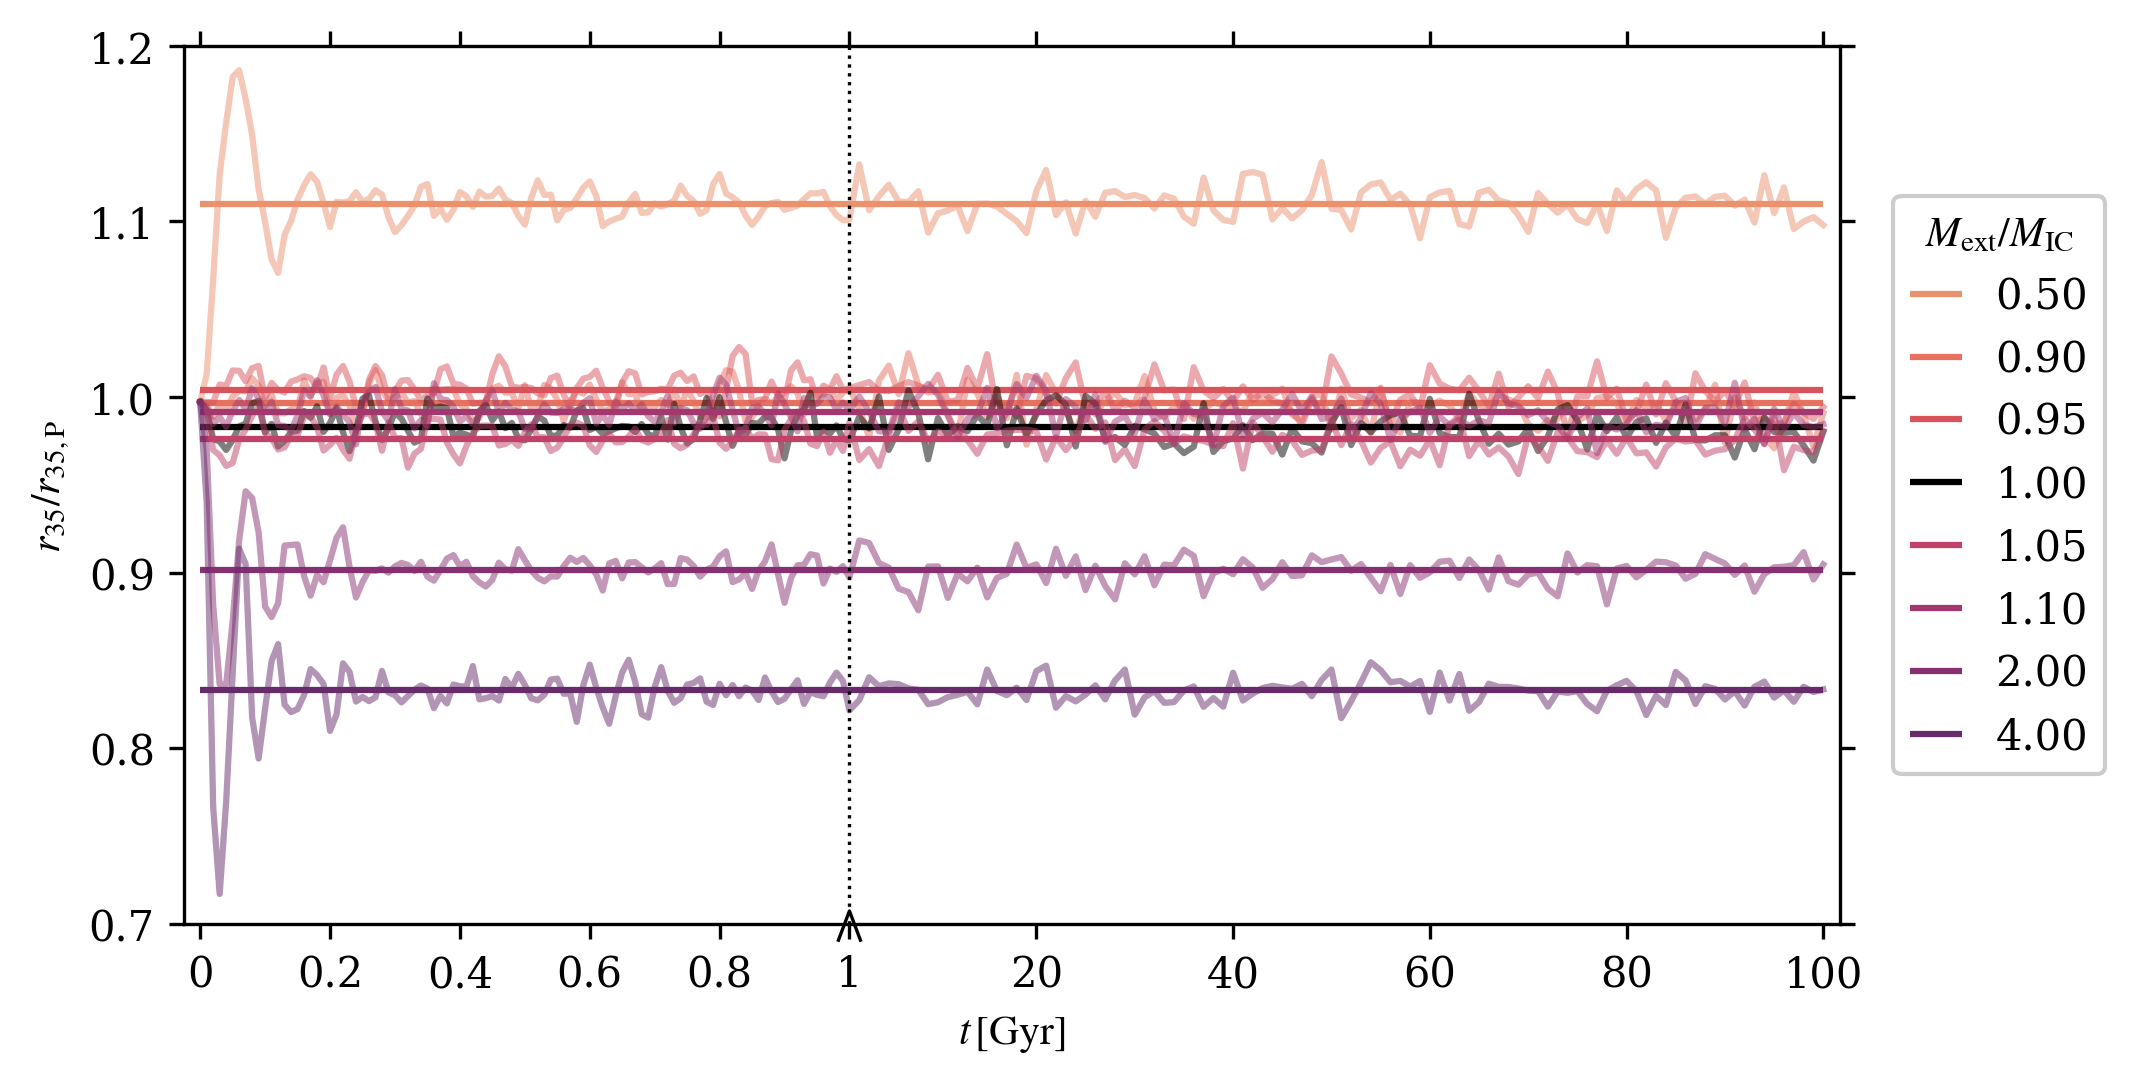

In [8]:
fig, ax = plt.subplots(figsize=(7, 3.5), layout='constrained')

axis_color = ax.spines["left"].get_edgecolor()
axis_width = ax.spines["left"].get_linewidth()

# Define parameters for the broken axis mapping
breaks = [0, 1, 100]
widths = [0.4, 0.6]
gap = 0

# Map original t values to two intervals broken at 1 Gyr
t = np.loadtxt('./outputlist.txt', dtype='float', unpack=True)
t_map = broken_axis_map(t, breaks=breaks, widths=widths, gap=gap)

# Lagrangian radius for the Plummer profile
r35_P = P.lagrangian_radius()

mass_ratio = [0.5, 0.9, 0.95, 1, 1.05, 1.1, 2, 4]

file_pattern = f'../data/lagrangian_radii/lagrangian_r35_*xMvir.txt'
file_list = sorted(glob(file_pattern))

for i, m in enumerate(mass_ratio):
    r = np.loadtxt(file_list[i], skiprows=1, unpack=True)

    # Individual outputs
    if mass_ratio[i] == 1:
        ax.plot(t_map, r / r35_P, color='black', linestyle='-', alpha=0.5)
    elif mass_ratio[i] < 1:
        ax.plot(t_map, r / r35_P, color=cmap_masses[i], alpha=0.5)
    else:
        ax.plot(t_map, r / r35_P, color=cmap_masses[i - 1], alpha=0.5)

    # Averages
    if mass_ratio[i] == 1:
        ax.hlines(np.mean(r) / r35_P, t_map.min(), t_map.max(), color='black', linestyle='-', label=f'{mass_ratio[i]:.2f}')
    elif mass_ratio[i] < 1:
        ax.hlines(np.mean(r) / r35_P, t_map.min(), t_map.max(), color=cmap_masses[i], label=f'{mass_ratio[i]:.2f}')
    else:
        ax.hlines(np.mean(r) / r35_P, t_map.min(), t_map.max(), color=cmap_masses[i - 1], label=f'{mass_ratio[i]:.2f}')

tick_vals = [0, 0.2, 0.4, 0.6, 0.8, 1, 20, 40, 60, 80, 100]             # real time values
tick_pos = broken_axis_map(np.array(tick_vals), breaks, widths, gap)    # mapped time values

ax.set_xticks(tick_pos)
ax.set_xticklabels([str(t) for t in tick_vals])

ax.set_ylim([0.7, 1.2])
ax.set_xlim([tick_pos[0]-0.01, tick_pos[-1]+0.01])

ax.set_ylabel(r'$r_{35} / r_{35, \mathrm{P}}$')
ax.set_xlabel(r'$t\,[\mathrm{Gyr}]$')

# Vertical dotted line at the break
ax.axvline(tick_pos[5], linestyle='dotted', linewidth=axis_width, color=axis_color)

gap_start = broken_axis_map(np.array([1.0]), breaks, widths, gap)[0]  # end of first region
gap_end = gap_start + gap                                             # start of second region
gap_center = 0.5 * (gap_start + gap_end)

# convert gap_center (data) -> fraction of axes width (0..1)
xlim = ax.get_xlim()
gap_center_frac = (gap_center - xlim[0]) / (xlim[1] - xlim[0])

# Small zigzag at the break (drawn in axes coordinates so it sits on the x-axis and doesn't depend on y-limits)
dx_axes = 0.007   # half-width of zigzag in axes fraction
dy_axes = 0.035   # vertical size in axes fraction
y0_axes = -0.02   # slightly below axis (clip_on=False needed)

xs_axes = [gap_center_frac - dx_axes, gap_center_frac, gap_center_frac + dx_axes]
ys_axes = [y0_axes, y0_axes + dy_axes, y0_axes]

# draw the zigzag with axes transform
ax.plot(xs_axes, ys_axes, transform=ax.transAxes, clip_on=False, linewidth=axis_width, color=axis_color, solid_capstyle='butt')

ax.legend(title=r'$M_\mathrm{ext} / M_\mathrm{IC}$', loc='center left', bbox_to_anchor=(1.02, 0.5))

## Stellar density fitting (figure 4)

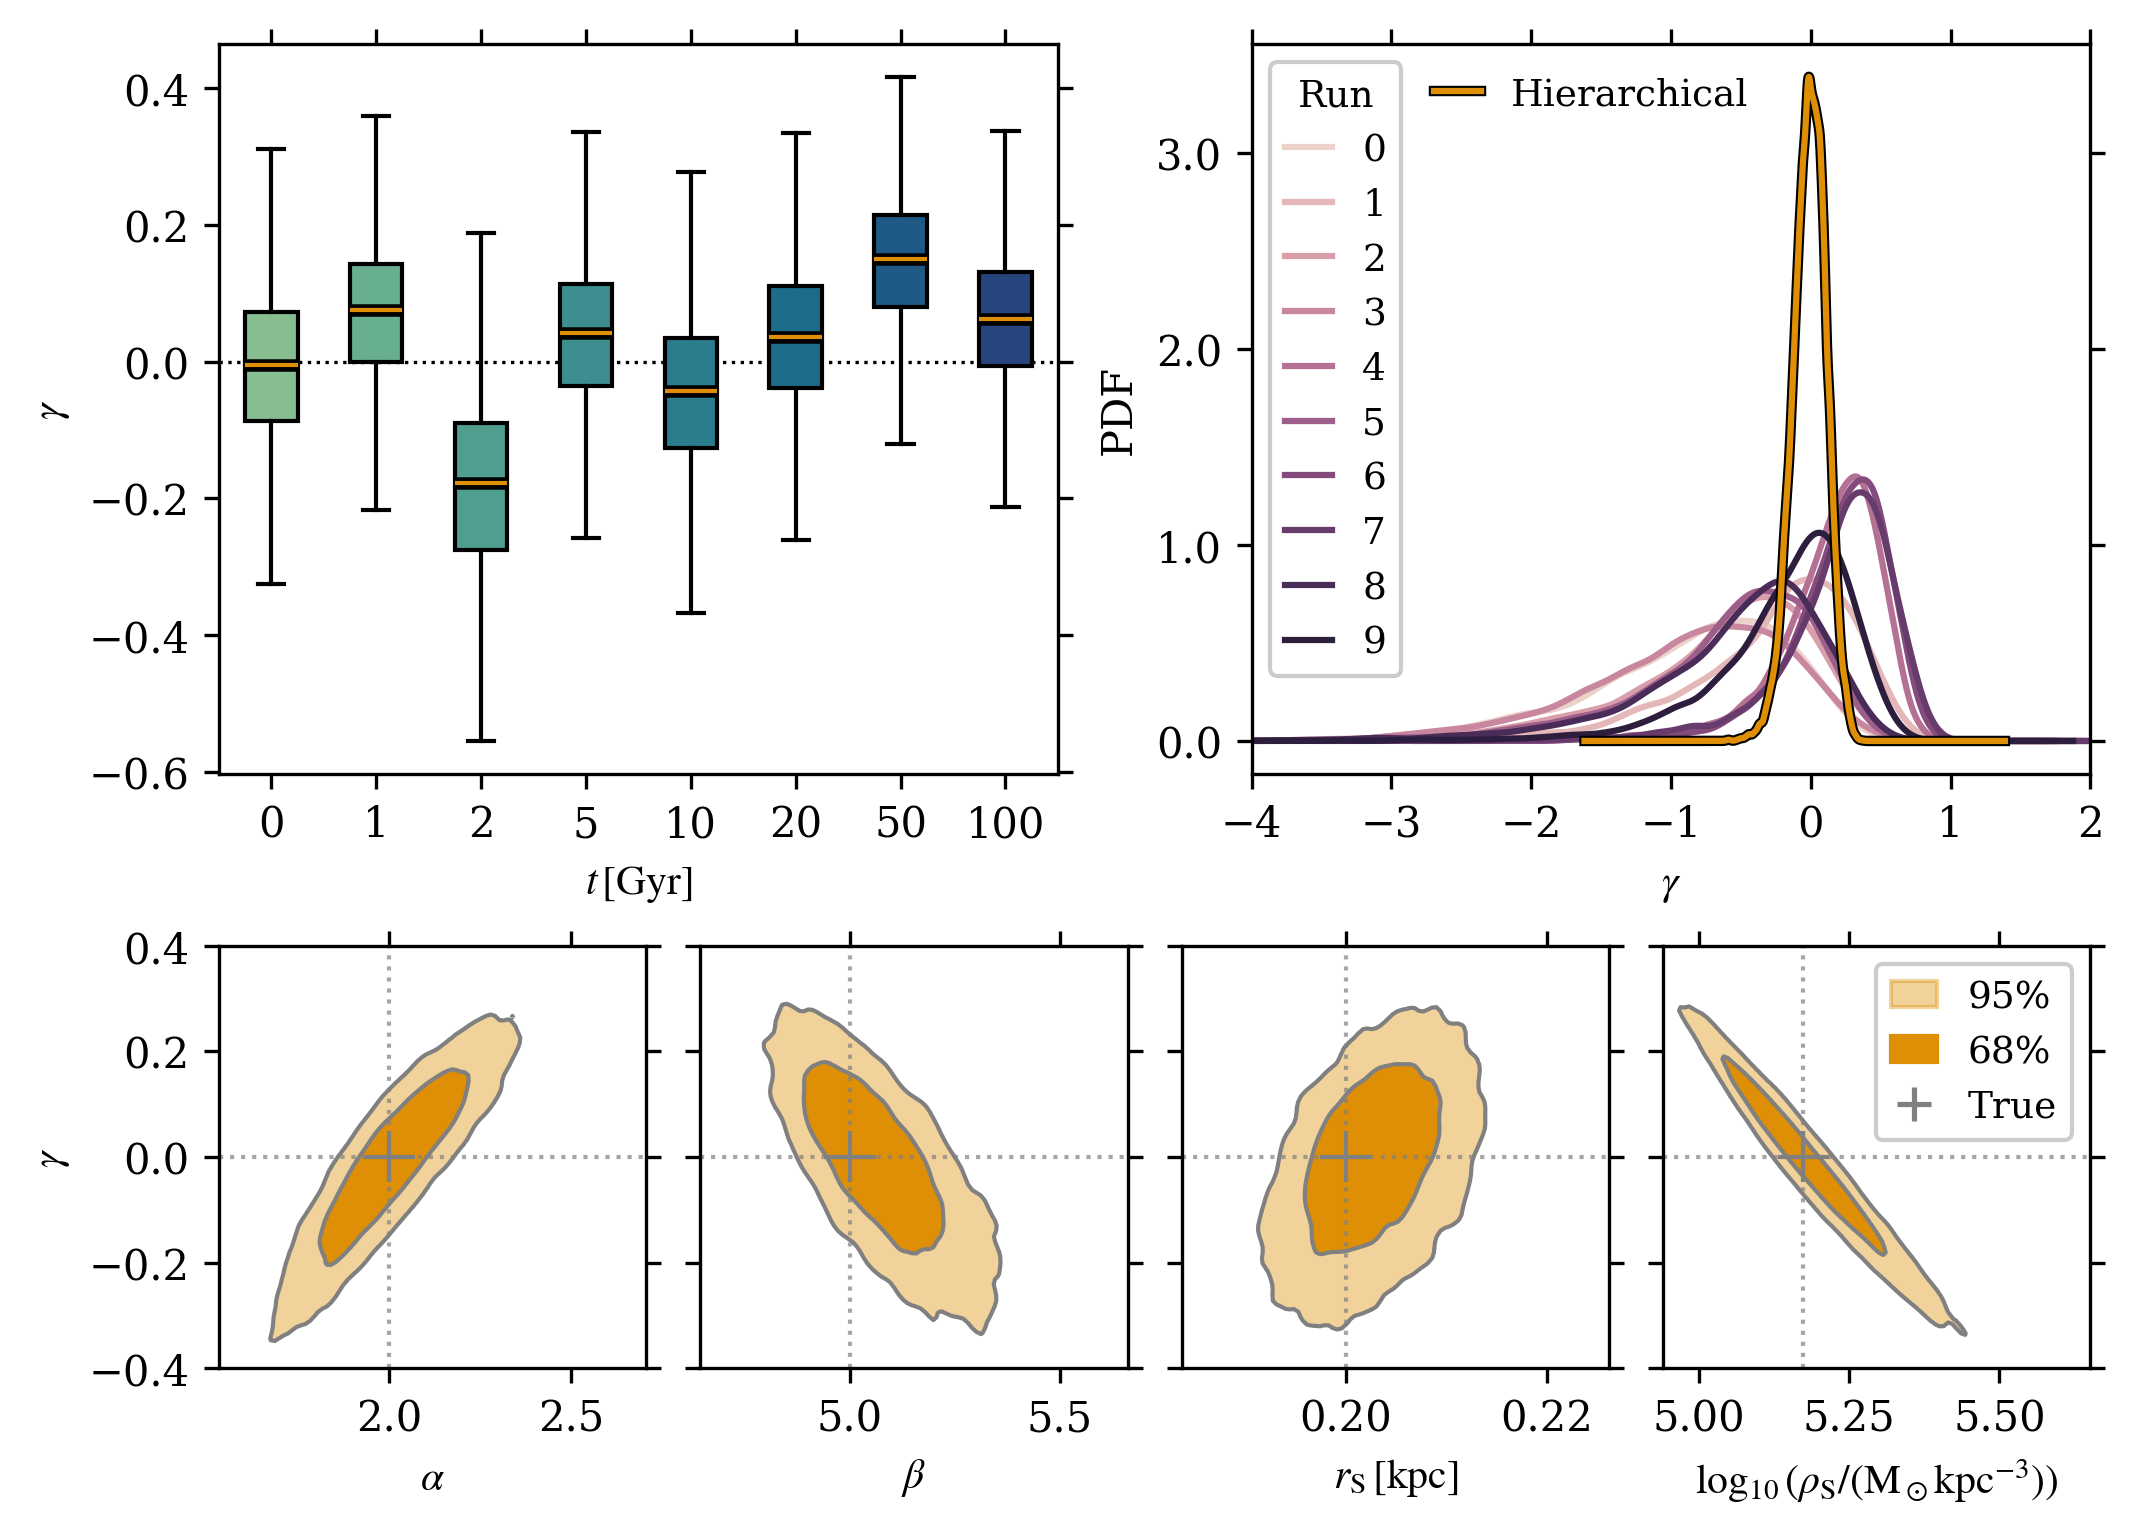

In [9]:
fig = plt.figure(figsize=(7, 5), layout='constrained')
outer = gs.GridSpec(2, 1, figure=fig, height_ratios=[1.5, 1])

top = gs.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[0])
bottom = gs.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[1])

### BOXPLOT ###

ax00 = fig.add_subplot(top[0])

file_pattern = f'../data/stellar_fitting/hierarchical/stellar_density_fiducial_***Gyr_cut95_nbins50_density_fit.npz'
file_list = sorted(glob(file_pattern))

axis_color = ax00.spines["left"].get_edgecolor()
axis_width = ax00.spines["left"].get_linewidth()

# gamma = 0
ax00.axhline(0, linestyle='dotted', linewidth=axis_width, color=axis_color)

# Load data
params = []
for i, file in enumerate(file_list):
    fit_data = np.load(file, allow_pickle=True)

    param = fit_data['g_posterior'].flatten()
    params.append(param)

# Make boxplot
years = [0, 1, 2, 5, 10, 20, 50, 100]
bp = ax00.boxplot(params, patch_artist=True, showfliers=False, tick_labels=years)

for patch, color in zip(bp['boxes'], cmap_times):
    patch.set_facecolor(color)

for median in bp['medians']:
    median.set(color=color_orange, linewidth=1, path_effects=[pe.Stroke(linewidth=3, foreground='k'), mpl.patheffects.Normal()])

ax00.set_ylabel(r'$\gamma$')
ax00.set_xlabel(r'$t\,[\mathrm{Gyr}]$')

### PDF ###

ax01 = fig.add_subplot(top[1])

# Non-hierarchical fits of individual runs
fiducials = []
for run in np.arange(10):
    file = f'../data/stellar_fitting/simple/stellar_density_fiducial_{run}_000Gyr_cut95_nbins50_density_fit.npz'
    fit_data = np.load(file, allow_pickle=True)

    gamma = fit_data['g']
    x_points = np.linspace(min(gamma) - 1, max(gamma) + 1, 1000)
    gamma_kde = gaussian_kde(gamma)
    gamma_pdf = gamma_kde(x_points)

    fiducials += ax01.plot(x_points, gamma_pdf, label=f'{run}', color=cmap_fiducials[run])

# Hierarchical fit
file = f'../data/stellar_fitting/hierarchical/stellar_density_fiducial_000Gyr_cut95_nbins50_density_fit.npz'
fit_data = np.load(file, allow_pickle=True)

gamma = fit_data['g_posterior'].flatten()
x_points = np.linspace(min(gamma) - 1, max(gamma) + 1, 1000)
gamma_kde = gaussian_kde(gamma)
gamma_pdf = gamma_kde(x_points)

hierarchical1 = ax01.plot(x_points, gamma_pdf, color='k', label=' ', linewidth=2.5)
hierarchical2 = ax01.plot(x_points, gamma_pdf, color=color_orange, label='Hierarchical')

ax01.set_ylabel('PDF')
ax01.set_xlabel(r'$\gamma$')

ax01.set_xlim([-4, 2])

ax01.set_yticks([0, 1, 2, 3])
ax01.set_yticklabels([0.0, 1.0, 2.0, 3.0])

ax01legend1 = ax01.legend(handles=hierarchical1, frameon=False, loc=(0.2, 0.885), fontsize=9)
ax01.add_artist(ax01legend1)

ax01legend2 = ax01.legend(handles=hierarchical2, framealpha=0, loc=(0.2, 0.885), fontsize=9)
ax01.add_artist(ax01legend2)

ax01.legend(handles=fiducials, title='Run', loc='upper left', fontsize=9, title_fontsize=9, ncol=1)

### CONTOUR PLOTS ###

file = f'../data/stellar_fitting/hierarchical/stellar_density_fiducial_000Gyr_cut95_nbins50_density_fit.npz'
fit_data = np.load(file, allow_pickle=True)

gamma = fit_data['g_posterior'].flatten()
beta = fit_data['b_posterior'].flatten()
alpha = fit_data['a_posterior'].flatten()
rS = fit_data['rS_posterior'].flatten()
rho = fit_data['log10rhoS_posterior'].flatten()

# True values for the parameters
gamma_true = 0.0
params = [alpha, beta, rS, rho]
params_true = [2.0, 5.0, 0.2, np.log10(P.rhoS)]

ax_labels = [r'$\alpha$', r'$\beta$', r'$r_\mathrm{S}\,[\mathrm{kpc}]$', r'$\log_{10}(\rho_\mathrm{S}/(\mathrm{M}_\odot \mathrm{kpc}^{-3}))$']

ax10 = fig.add_subplot(bottom[0])
ax11 = fig.add_subplot(bottom[1])
ax12 = fig.add_subplot(bottom[2])
ax13 = fig.add_subplot(bottom[3])

ax = [ax10, ax11, ax12, ax13]

for i, param in enumerate(params):
    data = np.vstack([param, gamma])
    kde = gaussian_kde(data)

    # Evaluate KDE on grid
    nbins = 100
    param_range = np.linspace(param.min(), param.max(), nbins)
    g_range = np.linspace(gamma.min(), gamma.max(), nbins)
    PARAM, G = np.meshgrid(param_range, g_range)
    positions = np.vstack([PARAM.ravel(), G.ravel()])
    Z = np.reshape(kde(positions), G.shape)

    # Compute contour intervals
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    cumsum = np.cumsum(Z_sorted)
    cumsum /= cumsum[-1]

    # Find density thresholds for given credible levels (68%, 95%)
    credible_probs = [0.68, 0.95]
    levels = [Z_sorted[np.searchsorted(cumsum, p)] for p in credible_probs]
    levels = sorted(levels)

    # Define contour colours
    cmap = [mpl.colors.to_rgba(color_orange, alpha=0.4), mpl.colors.to_rgba(color_orange, alpha=1)]

    # Plot the contours
    contour = ax[i].contourf(PARAM, G, Z, levels=levels + [Z.max()], colors=cmap)
    ax[i].contour(PARAM, G, Z, levels=levels, colors='gray', linewidths=1)

    ax[i].scatter(params_true[i], gamma_true, c='gray', marker='+', s=150, linewidths=1)
    ax[i].axvline(params_true[i], color='gray', linestyle=':', linewidth=1, alpha=0.7)
    ax[i].axhline(gamma_true, color='gray', linestyle=':', linewidth=1, alpha=0.7)

    ax[i].set_ylim([-0.4, 0.4])

    ax[i].set_xlabel(ax_labels[i])

    if i > 0:
        ax[i].set_yticklabels([])

ax[0].set_ylabel(r'$\gamma$')

# Create legend
patches = []
for i, p in enumerate(reversed(credible_probs)):
    patches.append(mpl.patches.Patch(color=cmap[i], label=f"{int(p*100)}%"))

true_marker = plt.Line2D([], [], color='gray', marker='+', linestyle='None', markersize=8, markeredgewidth=1.25, label='True')

ax[3].legend(handles=patches + [true_marker], loc='upper right', fontsize=9)